# Ant Colony Optimization
Jaraad Kamal

In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from threading import Thread

## The Ant
Creating a structure to hold information needed by each ant

In [37]:
class AntInfo:
    def __init__(
            self, 
            start_pos: int,
            graph: np.matrix,
            graph_dist_desir: np.matrix,
            pheromone_trails: np.matrix,
            pheromone_desirability_weight: int,
            indices: list[int],
            ones: np.matrix
            ):

        # indicies is a shared list from 0 to max_indices that is used by all
        # ants. SHOULD BE UNTOUCHED
        self.INDICES = indices

        # ones is a shared list 1s used by
        # ants. SHOULD BE UNTOUCHED. Idea was because do not want to creat
        # a new matrix every time an ant is created (reduced speed)
        self.ONES = ones

        # phermone desirability weight is to account for how much each ant
        # prefers pheremones (SAME FOR ENTIRE CLASS)
        self.pheromone_desirability_weight = pheromone_desirability_weight

        verts, verts2 = graph.shape
        if verts != verts2:
            raise ValueError('matrix must be square')
        if graph_dist_desir.shape != (verts, verts2):
            raise ValueError('Graphs must be same size')
        if (verts, verts2) != pheromone_trails.shape:
            raise ValueError('pheromones must be same shape')
        
        self.num_vertices = verts
        self.start_pos = start_pos
        self.graph = graph
        self.graph_dist_desir = graph_dist_desir
        self.pheromone_trails = pheromone_trails

        # value that will hold the path found by the thread
        self.return_val = None

## The Ant Logic
The following is the basic ant brain. This code represents the decision tree that each individual ant will undergo.
From a given starting point it will randomly choose an edge. It will perfer edges that are closer (shorter distances) and have high amounts of pheromones

In [38]:
def ant_follow(ant_info: AntInfo) -> None:
    """
    Given an ant info parameter it will start at a position and 
    pseduo-randomly follow paths to complete the graph.

    When selecting next edge to follow it will chose one that goes to an 
    unvisited node. Then it will do a weighted probability based on the 
    current pheromone strength and the distance to the point (perfering 
    stronger pheromone and shorter distances)

    The calculations will be stored in the ant_info parameter under return 
    val. This is to get information out of the threaded application.

    THREAD SAFE
    """
    # keeping track of visited locations
    visited = [1] * ant_info.num_vertices
    # we visit first by default
    visited[ant_info.start_pos] = 0
    current_pos = ant_info.start_pos
    path = [None] * (ant_info.num_vertices)
    total_cost = 0
    pheromone_bias = lambda x: np.power(x, ant_info.pheromone_desirability_weight)

    for i in range(0, ant_info.num_vertices - 1):
        # 
        # desirabilities is the desiability from the given graph * pheromones
        # which is done element by element

        

        # each individual desirability should be:
        # (inverse_dist ^ des_weight) * (pheromone_trail_val ^ pheromone_weight)
        # the exponents should be already accounted in the matrices.
        # the adding 1 to all pheromone values is to prevent pheromone values
        # from ever hitting zero and then having the entire weight be 0
        desirabilities = np.multiply(
            ant_info.graph_dist_desir[current_pos, :],
            np.add(
                ant_info.ONES, 
                pheromone_bias(ant_info.pheromone_trails[current_pos, :])
            )
        )
        # multiplying by visited because if visited is 0 then we have been there
        # and the probability goes to 0
        desirabilities = np.multiply(desirabilities, visited)

        # weird tolist()[0] is because random.choices only accepts lists
        # and because desiribility is a matrix the tolist() function will
        # return a list of lists instead of just a single row list
        next_node = random.choices(
            ant_info.INDICES, desirabilities.tolist()[0])[0]
        # updating visited
        visited[next_node] = 0
        path[i] = (current_pos, next_node)
        total_cost += ant_info.graph[path[i]]
        current_pos = next_node
    
    # now we must return back to start
    path[-1] = path[-2][1], ant_info.start_pos
    total_cost += ant_info.graph[path[-1]]

    # putting the return val in the ant_info parameter
    ant_info.return_val = total_cost, path
        
        

## The Algorithm
This will set off a bunch of ants to find an approximate solution to the 
traveling saleman problem. See comments for details.
<br>
Will return a float and 2 matrices. 
- The float is the total cost by of the journey for the best ant.
- The first matrix is the best path found at the end of all iteration.
- The second matrix is the pheromone matrix that was the final phermone trail

In [39]:
def ant_optimization(
        graph: np.matrix, 
        num_ants: int = 10, 
        num_iterations: int = 100, 
        desirability_weight: float = 2.0, 
        pheromone_desirability_weight: float = 1,
        pheromone_deposition_factor: float = 5.0,
        pheromone_evaporation_factor: float = 0.8,
        thread: bool = False) -> (float, np.matrix, np.matrix):
    
    """
    Function that sets up ant colony optimization.
    It will set up a series of ants determined by num_ants to explore the 
    graph using the ant_folow algorithm. 
    
    Each of the ants will start on a random
    vertex. The amount each ant prefers the closer node is determined by the
    desirability_weight. Ants will also perfer paths that are soaked in 
    pheromones (pheromones are left after an ant in a previous iteraion followed 
    the edge in question). The amount they prefer 
    pheromones is determined by pheromone_desirability_weight.

    It will then evaporate the pheromones on all paths. This is to prevent
    too much reinforcement to potentially bad starting guesses. The evaporation
    rate is determined by the pheromone_evaporation_factor 

    Then after it is all finished it will go through each of the paths
    the ants took and deposite pheromones in a separate matrix to indicate to 
    future ants that the path is good. The amount of pheromones desposited 
    is determined by pheromone_deposition factor. 

    NOTE: 
        graph > 2x2 symmetrix matrix positive on everything but diagonal
        num_ants > 0
        num_iteraions > 0
        desirability_weight > 1
        pheromone_desirability_weight > 0
        pheromone_deposition_factor > 0
        pheromone_evaporation_factor: positive < 1
        thread -> usually slower if small number of ants

    NOTE: 
        overflow errors are due to either the pheromone not evaporating enough
        (0.8 is a good factor) or the pheromone_desirability_factor being too 
        high.

        
    """
    
    num_verts, _num_verts = graph.shape
    if num_verts != _num_verts:
        raise ValueError('Graph must be a square graph')
    
    # making sure matrix is symmetric. (meaning graph is undirected)
    if not np.all(graph == graph.T):
        raise ValueError('Graph must be undirected')

    # making sure all entry values are less than 1
    max_val = graph.max()
    graph = (1 / max_val) * graph
    
    # putting a 1 in the diagonal just caust it makes checking for non zero 
    # distances really fast
    graph = graph + np.identity(num_verts)

    # checking if all non zero
    if not np.all(graph):
        raise ValueError('Graph must be completely connected')
    
    # doing the subtraction once to get the percentage of pheromones that stay
    # after each round
    evaporation_factor = 1 - pheromone_evaporation_factor

    # we will first convert all the distances in graph into raw desirablily 
    # values. This will basically take the inverse distance and raise it 
    # to the desirability weight
    dist_to_desire = lambda x: np.power((1/x), desirability_weight)

    # necessary info for running the ants.
    pheromones = np.zeros((num_verts, num_verts))
    graph_dist_desir = dist_to_desire(graph)
    INDICES = [i for i in range(0, num_verts)]
    ONES = np.ones((1,num_verts))

    # setting up each thread
    threads = [None] * num_ants
    ant_infos = [None] * num_ants
    ant_ranks = [None] * num_ants

    for iteration in range(0, num_iterations):
        for i in range(0, num_ants):
            ant_info = AntInfo(
                start_pos=random.randint(0, num_verts - 1),
                graph=graph,
                graph_dist_desir=graph_dist_desir,
                pheromone_trails=pheromones,
                indices=INDICES, 
                pheromone_desirability_weight = pheromone_desirability_weight,
                ones=ONES
            )
            ant_infos[i] = ant_info

            if thread:
                threads[i] = Thread(target=ant_follow, args=[ant_info])
                # starting the thread
                threads[i].start()
            else:
                ant_follow(ant_info)
        
        if thread:
            # stopping the threads
            for t in threads:
                t.join()

        # we just ran all the ants for one round.
        # we must now update the pheromone trails.
        
        # first we need to add some 'evaporation' to the pheromones on the 
        # current trail so that paths don't get permanetly reinforced.
        pheromones = evaporation_factor * pheromones

        for index, ant in enumerate(ant_infos):
            # getting the path cost and path from the ant
            ant_cost, path = ant.return_val
            pheromone_additon = pheromone_deposition_factor / ant_cost

            # ranking the ants only if on last iteration
            if iteration == num_iterations - 1:
                ant_ranks[index] = ant_cost
            for (row, col) in path:
                # row should never equal column because we dont travel to 
                # same node from node
                pheromones[col, row] += pheromone_additon
                pheromones[row, col] += pheromone_additon
        

    # getting the best from the last run
    best_ant = np.argmin(ant_ranks)
    best_price, path = ant_infos[best_ant].return_val
    best_path = np.zeros((num_verts, num_verts))
    for (row, col) in path:
        best_path[col, row] = 1
        best_path[row, col] = 1

    return best_price * max_val, best_path, pheromones


## Demonstration

In [40]:
def draw_graph(
        matrix: np.matrix, 
        pos: dict=None, 
        show: bool= True,
        weighted: bool= True, 
        file_name: str=None, 
        color: str='b',
        color_map=plt.cm.Blues) -> dict:
    """
    Given a matrix it will draw a graph with the weights. It will return the
    positions dictionary so that multiple graphs can have same node positions.
    """
    graph = nx.from_numpy_matrix(matrix)
    if pos is None:
        pos = nx.spring_layout(graph)
    if weighted:
        edges , weights = zip(*nx.get_edge_attributes(graph,'weight').items())
        nx.draw(graph, pos, node_color=color, 
            edgelist=edges, edge_color=weights, edge_cmap=color_map)
    else:
        nx.draw(graph, pos, node_color=color, edge_cmap=color_map)

    if file_name is not None:
        plt.savefig(file_name)
    if show:
        plt.show()
    return pos

In [41]:
def create_rand_graph(
        size: int, 
        max_coord: int=200) -> (np.matrix, list[tuple[int]]):
    """
    Given a size it will return a symmetric matrix representing the graph.
    The matrix is 'random'
    """

    # getting list of positions
    positions = {
        i: (random.randint(0, max_coord), random.randint(0, max_coord)) 
        for i in range(0, size)
    }
    
    graph = np.zeros((size, size))

    # calculating distances
    for i in range(0, size):
        for j in range(i, size):
            (x1, y1) = positions[i]
            (x2, y2) = positions[j]
            dist = (x1 - x2) ** 2 + (y1 - y2) ** 2
            dist = np.power(dist, 0.5)
            graph[i,j] = dist
            graph[j,i] = dist

    return graph, positions

### Creating a Graph
Creating a random graph and visualizing.

In [42]:
# making graph with 52 towns
z, positions = create_rand_graph(52)

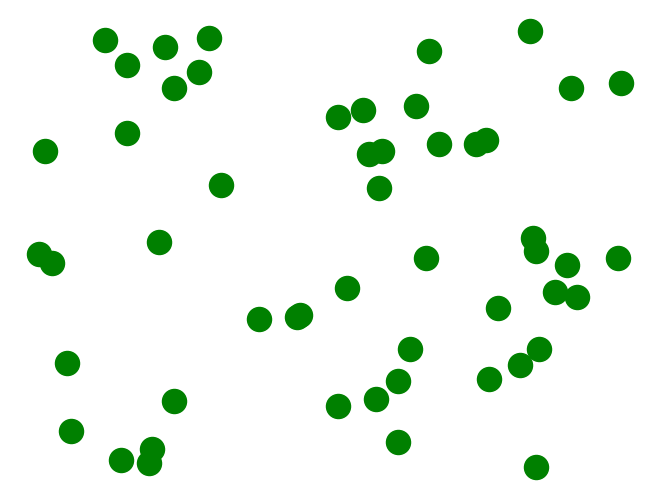

average cost per edge = 102.19582005404104


In [43]:
# passing in zeros because I don't want any edges drawn
_ = draw_graph(np.zeros(z.shape), positions, weighted=False, 
    color='g', file_name='Ant_52_nodes_map')
print('average cost per edge =', np.average(z))

### Using Algorithm

#### 10 Iteration Solution

In [44]:
cost, best_path, pheromone_trails = ant_optimization(
    z, num_ants=5, 
    num_iterations=10,
    pheromone_desirability_weight=2,
    pheromone_evaporation_factor=0.2
)
print('cost of journey:', cost)

cost of journey: 1595.2327900432347


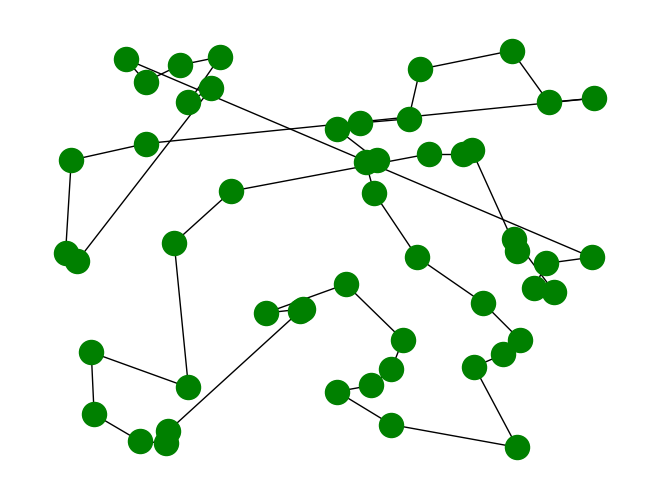

In [45]:
_ = draw_graph(
    best_path, pos=positions, 
    color='g', color_map=plt.cm.Greens, 
    weighted=False, file_name='Ant_52_nodes_10_iterations')

#### 1000 Interation Solution

In [46]:
cost, best_path, pheromone_trails = ant_optimization(
    z, num_ants=5, 
    num_iterations=1000, 
    pheromone_desirability_weight=2,
    pheromone_evaporation_factor=0.2
)
print('cost of journey:', cost)

cost of journey: 1311.0816240477477


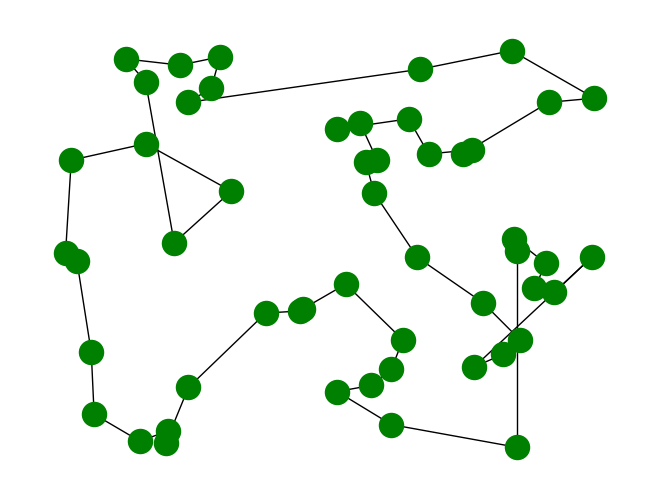

In [47]:
_ = draw_graph(best_path, pos=positions, 
    color='g', color_map=plt.cm.Greens, 
    weighted=False, file_name='Ant_52_nodes_1000_iterations')

### Visualizing Pheromone Trails
Out of curisoity lets look at the pheromone trails to get a sense of what each ant is seeing.
<br>
The darker an edge the more pheromones on the edge. These are the edges that the ants will prefer as they travel.

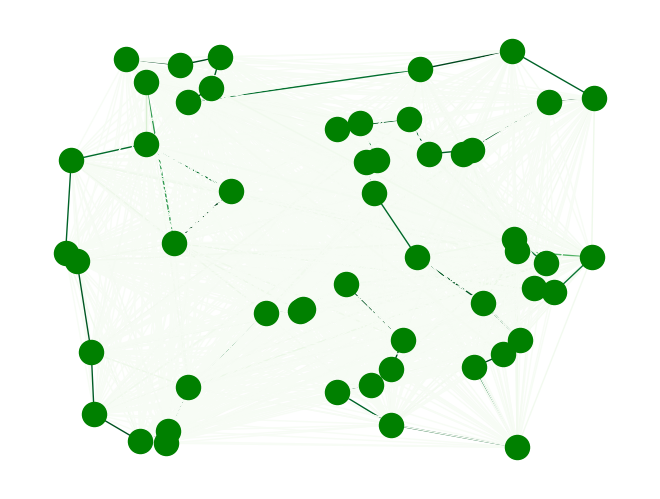

In [48]:
_ = draw_graph(pheromone_trails, pos=positions, 
    color='g', color_map=plt.cm.Greens,
    file_name='Ant_52_nodes_1000_iterations_pheromones')